# Visualization of Gel Formulation Analysis Results

This notebook imports analysis functions and performs visualization only. All data processing logic lives in the `analysis` Python modules.

In [1]:

# Imports (statistical analysis & visualization only)
from pathlib import Path
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure project root (parent of this 'results' dir) is on sys.path
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'results' else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from dataloader import GelDataLoader, load_raw_data
from data_analysis import (
    compute_basic_stats,
    compute_missing_values,
    compute_numeric_correlations,
    detect_outliers_iqr,
    perform_pca,
    build_correlation_heataverage_precision,
    build_feature_distributions
)

print('Imports ready')

Imports ready


In [2]:
# Development helper: always use latest code when modules change
%load_ext autoreload
%autoreload 2

# Optional: manual reload helper
from importlib import reload as _reload
# Example usage after editing a module file:
# _reload(data_analysis)
print('Autoreload enabled (mode 2): modules auto-reloaded before execution)')

Autoreload enabled (mode 2): modules auto-reloaded before execution)


In [3]:
# Dev utilities: force (hard) reload of project modules if autoreload misses something
import importlib, sys, types, inspect

PROJECT_ROOT_STR = str(PROJECT_ROOT)

def force_clean_project_modules(include_subdirs=True, verbose=False):
    removed = []
    for name, mod in list(sys.modules.items()):
        if not isinstance(mod, types.ModuleType):
            continue
        path = getattr(mod, '__file__', None)
        if not path:
            continue
        if PROJECT_ROOT_STR in path and path.endswith('.py'):
            # Optionally filter out site-packages
            if 'site-packages' in path:
                continue
            if not include_subdirs:
                # Only top-level modules directly under root
                rel = Path(path).relative_to(PROJECT_ROOT)
                if len(rel.parts) > 2:  # e.g., sub/package/module.py
                    continue
            removed.append(name)
            sys.modules.pop(name, None)
    if verbose:
        print(f'Removed {len(removed)} modules:')
        for n in removed: print(' -', n)
    return removed

def hard_reload(*module_names):
    reloaded = []
    for name in module_names:
        if name not in sys.modules:
            __import__(name)
        try:
            importlib.reload(sys.modules[name])
            reloaded.append(name)
        except Exception as e:
            print(f'Failed to reload {name}: {e}')
    print('Hard reloaded:', reloaded)
    return reloaded

def reload_all_project_modules(verbose=False):
    count = 0
    for name, mod in list(sys.modules.items()):
        path = getattr(mod, '__file__', None)
        if path and PROJECT_ROOT_STR in path and path.endswith('.py') and 'site-packages' not in path:
            try:
                importlib.reload(mod)
                count += 1
            except Exception as e:
                if verbose:
                    print('Could not reload', name, e)
    print(f'Reloaded {count} project modules')

print("Dev utilities ready: use force_clean_project_modules(), reload_all_project_modules(), hard_reload('dataloader','data_analysis') as needed.")

Dev utilities ready: use force_clean_project_modules(), reload_all_project_modules(), hard_reload('dataloader','data_analysis') as needed.


In [4]:
# Configuration (analysis only) - uses absolute path based on PROJECT_ROOT
from dataloader import GEL_FORMULATION_INPUTS, PRINTING_CONDITION_INPUTS, PROPERTY_OUTPUTS, load_raw_data

config = {'data_path': str((PROJECT_ROOT /  'Data_average_new.csv').resolve()),
          'pca_components': 2
}

raw_df = load_raw_data(config['data_path'], drop_metadata=True)
print('Raw data loaded:', raw_df.shape)
for target_output in PROPERTY_OUTPUTS:
    config[target_output] = {
        'dataset_types': ['Optimization', 'Robustness', 'Mahsa'],
        'input_columns': GEL_FORMULATION_INPUTS + PRINTING_CONDITION_INPUTS,
        'target_column': target_output,
        'pca_components': 2,
    }


print('Config loaded for analysis:')
print('Data path:', config['data_path'])

Raw data loaded: (42, 11)
Config loaded for analysis:
Data path: E:\src\data\Data_average_new.csv


In [ ]:
# Load data (no transformations beyond loader filtering)
loaders = {}
for target_column in PROPERTY_OUTPUTS:
    loaders[target_column] = GelDataLoader(config['data_path'])
    X, y, meta = loaders[target_column].load(
        dataset_types=config[target_column]['dataset_types'],
        input_columns=config[target_column]['input_columns'],
        target_column=config[target_column]['target_column']
    )

    # Combine for analysis convenience
    full_df = pd.concat([X, y], axis=1)
    print('Shapes: X', X.shape, 'y', y.shape)
    print('Targets:', meta)
    full_df.head()
print(PROPERTY_OUTPUTS)

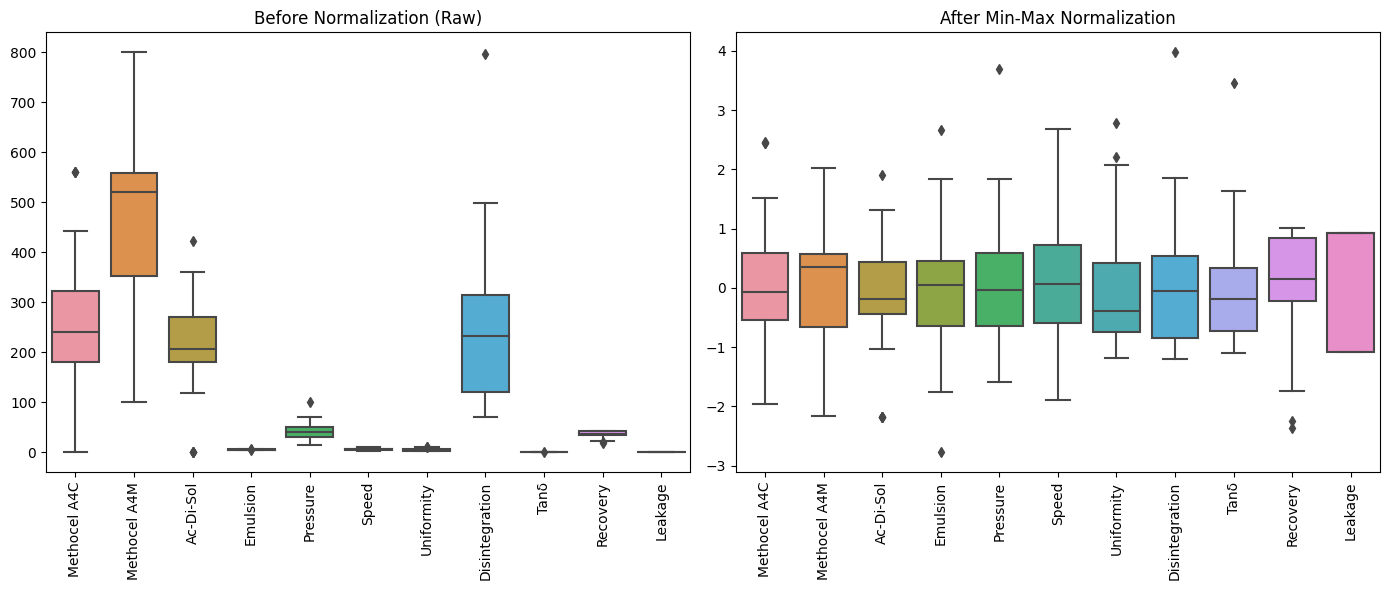

In [6]:
# Boxplots before and after normalization (Min-Max scaling)
from sklearn.preprocessing import StandardScaler

X = raw_df
numeric_cols = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X[numeric_cols])
X_scaled = pd.DataFrame(X_scaled_array, columns=numeric_cols, index=X.index)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Before
sns.boxplot(data=X[numeric_cols], ax=axes[0])
axes[0].set_title('Before Normalization (Raw)')
axes[0].tick_params(axis='x', rotation=90)
# After
sns.boxplot(data=X_scaled, ax=axes[1])
axes[1].set_title('After Min-Max Normalization')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

# Keep scaled version for later pair plots if desired
scaled_X_for_viz = X_scaled

In [7]:
# Statistical summaries
basic_stats = compute_basic_stats(raw_df)
missing = compute_missing_values(raw_df)
correlations = compute_numeric_correlations(raw_df)
outliers = detect_outliers_iqr(raw_df, return_indices=False)

# PCA (only on feature columns)
pca_df, pca_var, pca_model = perform_pca(raw_df, features=X.columns, n_components=config['pca_components'])
print('Explained variance ratio:', pca_var)

summary_bundle = {
    'basic': basic_stats,
    'missing_fraction': missing.to_dict(),
    'pca_variance_ratio': pca_var.tolist(),
    'outliers': outliers.to_dict(orient='records')
}



Explained variance ratio: [0.43826249 0.17954739]


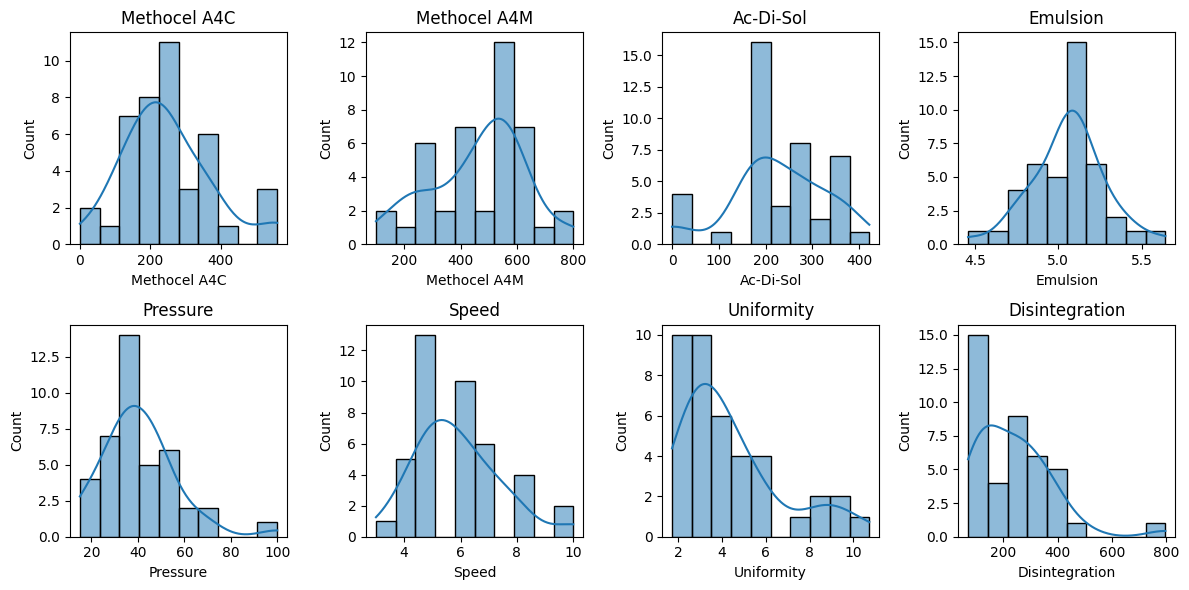

In [8]:
# Visualization: Feature distributions (subset of numeric features)
plt.figure(figsize=(12,6))
num_cols = raw_df.select_dtypes(include=[np.number]).columns.tolist()[:8]
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)
    sns.histplot(raw_df[col], bins=10, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

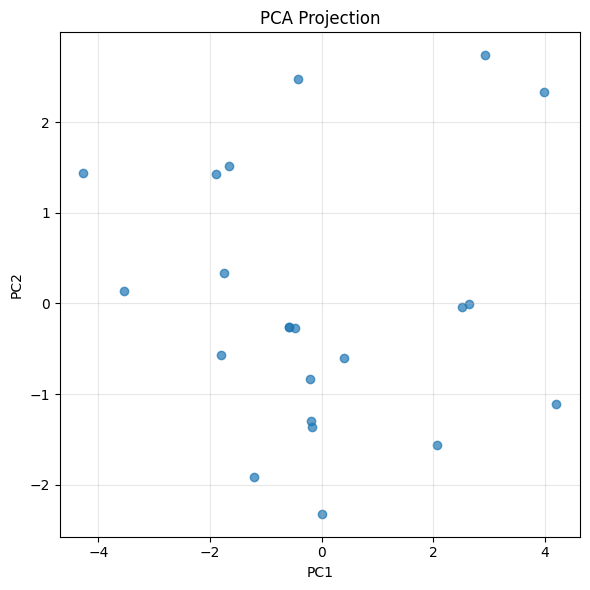

In [ ]:
# Visualization: PCA scatter (first two components)
if pca_df.shape[1] >= 2:
    plt.figure(figsize=(6,6))
    plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], alpha=0.7)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Projection')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('PCA has fewer than 2 components.')

In [ ]:
# Display summary bundle (truncated view)
from pprint import pprint
pprint({k: (v if k != 'outliers' else v[:3]) for k,v in summary_bundle.items()})  # show first few outlier rows

# Optional: save summary to JSON
summary_path = Path('results') / 'analysis_summary.json'
try:
    summary_path.write_text(json.dumps(summary_bundle, indent=2))
    print('Summary written to', summary_path)
except Exception as e:
    print('Could not write summary:', e)

Pairplot on columns: ['Methocel A4C', 'Methocel A4M', 'Ac-Di-Sol', 'Emulsion', 'Pressure', 'Speed', 'Uniformity', 'Disintegration', 'Tanδ', 'Recovery', 'Leakage']


AttributeError: module 'matplotlib.cm' has no attribute 'Scalaraverage_precisionpable'

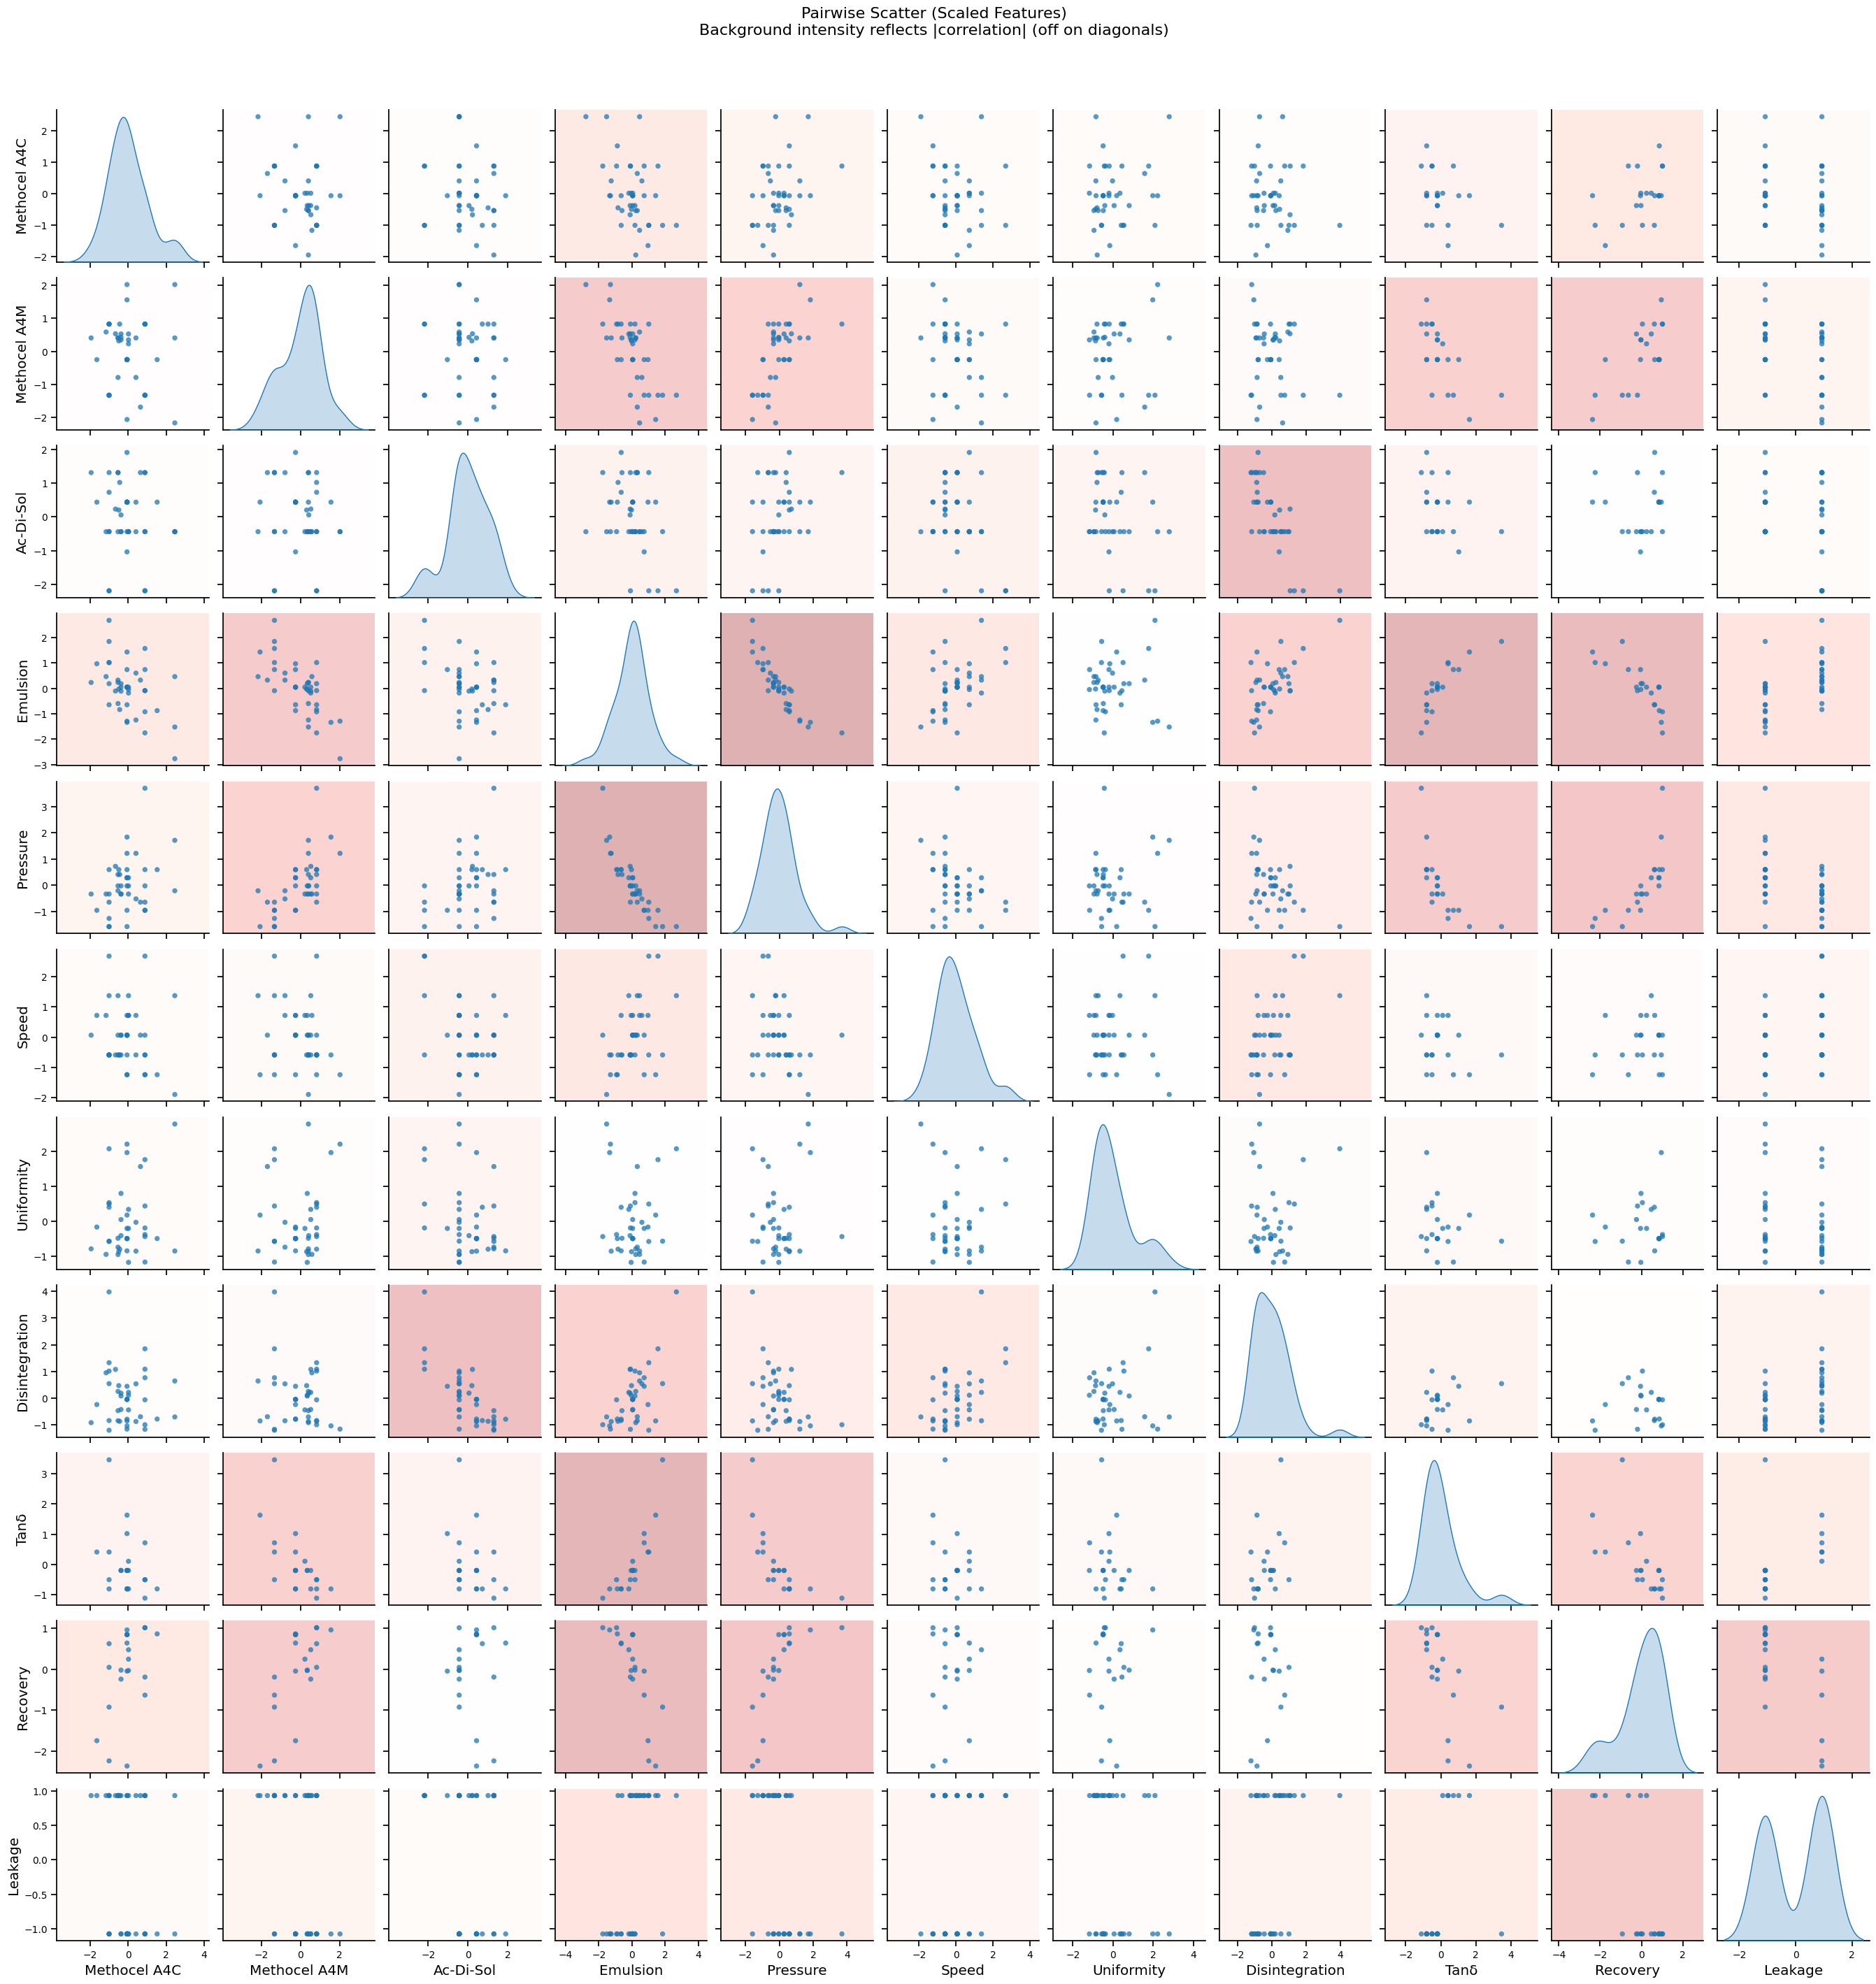

In [10]:
# Pairwise scatter plots (pairplot) for a subset of scaled numeric features
# Symmetric matrix, larger fonts, KDE diagonals, background color intensity ~ |correlation| (off on diagonals).
subset_cols = scaled_X_for_viz.columns  # limit to first 6 to avoid clutter
print('Pairplot on columns:', list(subset_cols))

sns.set_context('notebook', font_scale=1.2)

pp = sns.pairplot(
    scaled_X_for_viz[subset_cols],
    corner=False,          # full symmetric matrix
    diag_kind='kde',       # continuous KDE on diagonal
    plot_kws={'s': 28, 'alpha': 0.75, 'edgecolor': 'none'},
    diag_kws={'fill': True, 'common_norm': False}
)

# Compute absolute correlation matrix
abs_corr = scaled_X_for_viz[subset_cols].corr().abs()

# Coloraverage_precision for background (light to stronger tint)
import matplotlib as mpl
caverage_precision = mpl.cm.Reds

for i, y_var in enumerate(subset_cols):
    for j, x_var in enumerate(subset_cols):
        ax = pp.axes[i, j]
        if ax is None:
            continue
        # Leave diagonal (KDE) panels with default white background
        if i == j:
            ax.set_facecolor('white')
            continue
        val = abs_corr.loc[y_var, x_var]
        # Get base color from caverage_precision; lighten by blending toward white & control alpha
        r, g, b, _ = caverage_precision(val)
        blend = 0.65  # base blend toward white
        r = 1 - (1 - r) * (1 - blend * (1 - val))
        g = 1 - (1 - g) * (1 - blend * (1 - val))
        b = 1 - (1 - b) * (1 - blend * (1 - val))
        alpha = 0.12 + 0.25 * val  # keep translucent
        ax.set_facecolor((r, g, b, alpha))

pp.fig.suptitle('Pairwise Scatter (Scaled Features)\nBackground intensity reflects |correlation| (off on diagonals)', y=1.04, fontsize=16)

# Tweak tick label size
for ax in pp.axes.flatten():
    if ax is not None:
        ax.tick_params(labelsize=10)

# Optional: add a mini colorbar for reference
from matplotlib.colors import Normalize
sm = mpl.cm.Scalaraverage_precisionpable(caverage_precision=caverage_precision, norm=Normalize(vmin=0, vmax=1))
sm.set_array([])
cb = pp.fig.colorbar(sm, ax=pp.axes, fraction=0.025, pad=0.02)
cb.set_label('|Correlation|', rotation=270, labelpad=14)

plt.show()